In [84]:
#Importing packages
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import copy
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn import mixture
import umap
import random
import pandas as pd

In [85]:
#Setting random seeds
seed = 7
np.random.seed(seed)
random.seed(7)

In [86]:
#Loading PK data and preprocessing
pk_a_1 = np.load("pk_a_1.npy")
ain = np.abs(np.reshape(np.array(pk_a_1),(-1,10)))

tags = ["Generic-Tag","Tag-6","Tag-8","Tag-9","Tag-12","Tag-17"]
biotin = ["6-Biotin","8-Biotin","9-Biotin","12-Biotin","17-Biotin"]
ant = ['1 ug']
form = ['1','2','3','4','5','6']
pl = []
pl2 = []
for i in range(len(ain)):
    a = i//180 #1 for pk_a_1 and 0 for pk_a_25
    g = i + 1 - (180*a)
    f = g%30 # if the last it is 0
    F = g//30 - (0 ** f)
    b = g%6 # if the last it is 0
    B = (g - (F*30))//6  - (0**b)
    T = g%6
    pl.append(tags[T]+"/"+biotin[B]+ " antigen ["+ant[a]+"] format "+form[F])
    pl2.append([T,B,a,F])

#pk_a shape is 180 by 10 (anal. vals), first dimension is the six tags repeated
#for each of the five biotin-IDs which in turn
#is repeated for each six formats

In [87]:
#Defining helper functions
mmft = MinMaxScaler().fit_transform

def thresh_h(val):
    if val == 0:
        plt.plot([200,200],[-0.1,.1],c='grey')
        plt.plot([750,750],[-0.1,.1],c='grey')
    if val in (1,2):
        plt.plot([65000,65000],[-0.1,.1],c='grey')
        plt.plot([100000,100000],[-0.1,.1],c='grey')
    if val in (3,4):
        plt.plot([500,500],[-0.1,.1],c='grey')
        plt.plot([1000,1000],[-0.1,.1],c='grey')
    if val in (5,6):
        plt.plot([3,3],[-0.1,.1],c='grey')
        plt.plot([5,5],[-0.1,.1],c='grey')
        plt.plot([10,10],[-0.1,.1],c='grey')
    if val in (7,8,9):
        plt.plot([30,30],[-0.1,.1],c='grey')
        plt.plot([20,20],[-0.1,.1],c='grey')
        plt.plot([10,10],[-0.1,.1],c='grey')

def pk_bd_s(inp,nu):
    inp = np.abs(inp)
    if nu in [0,7,8,9]:
        org = (min(inp[:,0]),np.argmin(inp[:,0]))
    else:
        org = (max(inp[:,0]),np.argmax(inp[:,0]))
    return(org)

def get_best_s(inp,nu):
    ind = pk_bd_s(inp,nu)
    return(ind)

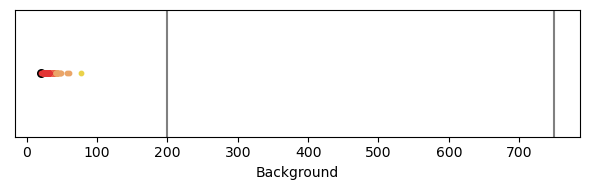

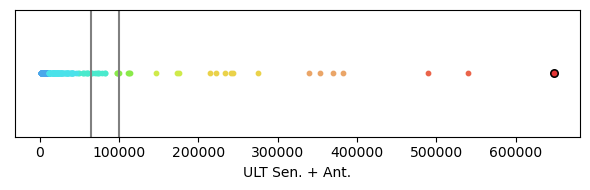

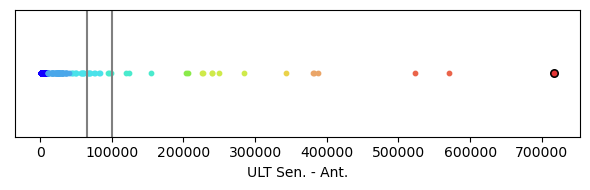

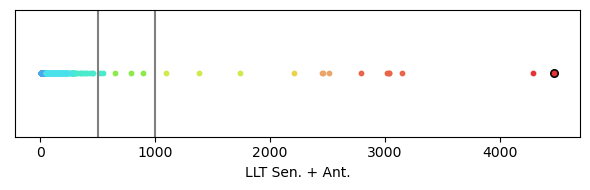

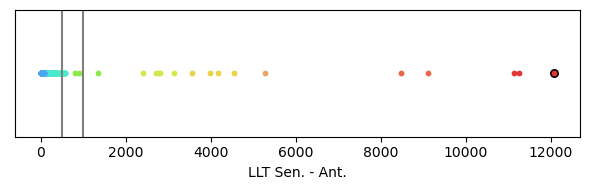

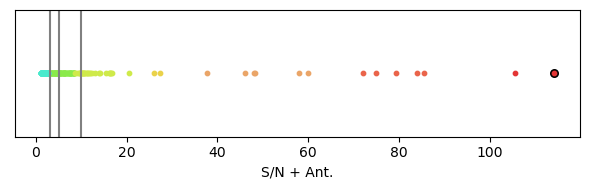

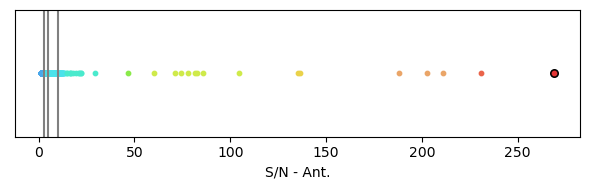

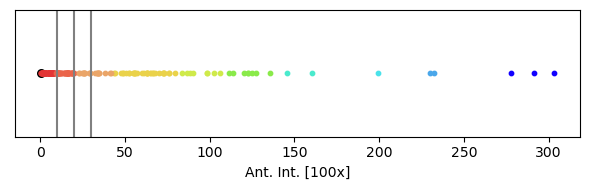

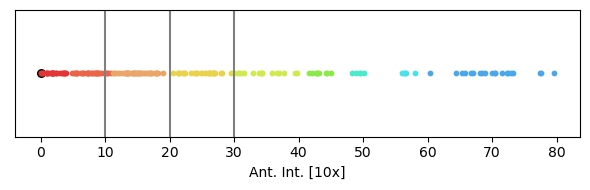

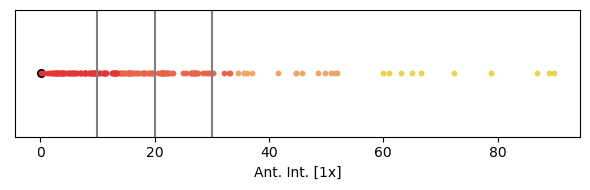

In [88]:
#Running single metric GMMs for the sake of reproducibility of the subsequent multi-metric GMM
def sm_ggm(inp,metric="aic"):
    metric = metric
    bil = []
    title_l = ['Background','ULT Sen. + Ant.','ULT Sen. - Ant.','LLT Sen. + Ant.',
               'LLT Sen. - Ant.','S/N + Ant.','S/N - Ant.',"Ant. Int. [100x]",
               "Ant. Int. [10x]","Ant. Int. [1x]"]
    for i1 in np.arange(10):
        gmm_10.append([])
        gmm_10[-1].append(title_l[i1])
        avv = np.array([inp[:,i1],np.zeros(len(inp))]).transpose()
        avv2 = avv
        lowest_bic = np.infty
        bic = []
        n_components_range = range(4, 11)
        cv_types = ['diag']
        for cv_type in cv_types:
            for n_components in n_components_range:
                # Fit a Gaussian mixture with EM
                gmm = mixture.GaussianMixture(n_components=n_components,
                                            covariance_type=cv_type)
                gmm.fit(avv2)
                if metric == 'bic':
                    bic.append(gmm.bic(avv2))
                elif metric == 'aic':
                    bic.append(gmm.aic(avv2))
                elif metric == 'score':
                    bic.append(-1*gmm.score(avv2))
                gmm_10[-1].append(bic[-1])
                if bic[-1] < lowest_bic:
                    lowest_bic = bic[-1]
                    best_gmm = gmm
                    
        bic = np.array(bic)
        color_iter = itertools.cycle(['#1100FF', '#4AA7EA','#4AE2EA','#4AEACD','#8AEA4A' ,'#CFEA4A','#EAD24A','#EAA568', "#EA644A" ,"#E33535"])
        clf = best_gmm
        plt.figure(figsize=(6, 2))
        # Plot the winner
        splot = plt.subplot(1, 1, 1)
        Y_ = clf.predict(avv2)
        bil.append(get_best_s(avv,i1))
        plt.scatter(get_best_s(avv,i1)[0],0,c='k',s=30)
        thresh_h(i1)
        colors = ['#1100FF', '#4AA7EA','#4AE2EA','#4AEACD','#8AEA4A' ,'#CFEA4A','#EAD24A','#EAA568', "#EA644A" ,"#E33535"]
        colors.reverse()
        Y_v_list = []
        for i in range(max(Y_)+1):
            Y_v = [avv[v[0],0] for v in enumerate(Y_) if v[1] == i]
            Y_v_list.append(np.mean(Y_v))#appends max value by increasing Y_ labels
        Y_v_list_2 = copy.deepcopy(Y_v_list)
        colors_p = copy.deepcopy(colors)
        if i1 not in (0,7,8,9):
            Y_v_list = [-v for v in Y_v_list]
        cl = np.arange(10)
        cl = list(cl)
        Y_score = []
        for sort_val in enumerate(np.argsort(Y_v_list)):
            sc = colors_p[sort_val[0]]
            Y_score.append(cl[sort_val[1]])
            cl[sort_val[1]] = str(sc)

        #mapping Y_ indexes to scores
        if i1 in (0,7,8,9):
            Y_score.reverse()

        for index_v in enumerate(Y_):
            gmm_10_scores[index_v[0]+1].append(Y_score.index(index_v[1]))

        for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                                color_iter)):
            op = 1
            if not np.any(Y_ == i):
                continue
            
            plt.scatter(avv[Y_ == i, 0], avv[Y_ == i, 1], 10, color=cl[i])
        nc = np.mod(bic.argmin(), len(n_components_range)) + 2
        ct = cv_types[int(np.floor(bic.argmin() / len(n_components_range)))]
        splot.set_ylim([-.01, .01])
        plt.xlabel(title_l[i1])
        plt.yticks(())
        plt.subplots_adjust(hspace=.35, bottom=.02)
        plt.tight_layout()
        #plt.savefig("pk_gmm_{0}_1ug.pdf".format(i1),dpi=300)
        plt.show()

gmm_10 = [["Analytical Metric","4 Components",
          "5 Components", "6 Components", "7 Components", "8 Components", "9 Components",
          "10 Components"]]
          
gmm_10_scores = [["PKA Conditions",'Background','ULT Sen. + Ant.','ULT Sen. - Ant.','LLT Sen. + Ant.',
                  'LLT Sen. - Ant.','S/N + Ant.','S/N - Ant.',"Ant. Int. [100x]",
                  "Ant. Int. [10x]","Ant. Int. [1x]","Total"]]

for i in range(len(ain)):
    gmm_10_scores.append([pl[i]])

sm_ggm(np.abs(np.reshape(np.array(pk_a_1),(-1,10))))

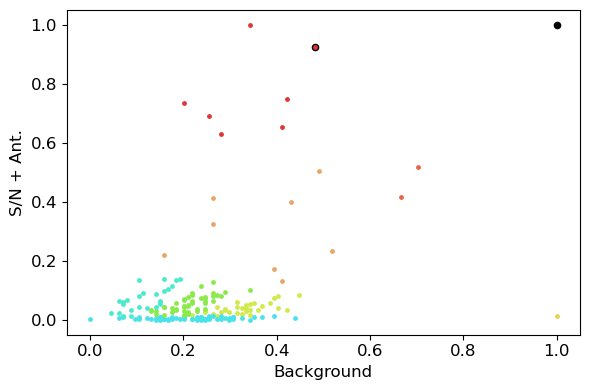

In [89]:
#Fitting and plotting 2D GMM, again needed for reproducibility of the subsequent multi-metric GMM

def pk_bd_2d(inp,nu):
    inp = np.abs(inp)
    if nu in [0,7,8,9]:
        org = (min(inp[:]),np.argmin(inp[:]))
    else:
        org = (max(inp[:]),np.argmax(inp[:]))
    return(org)



def sm_ggm2(inp):
    bil = []
    title_l = ['Background','ULOQ Sen. + Ant.','ULOQ Sen. - Ant.','LLOQ Sen. + Ant.',
               'LLOQ Sen. - Ant.','S/N + Ant.','S/N - Ant.',"Ant. Int. [100x]",
               "Ant. Int. [10x]","Ant. Int. [1x]"]
    avv = np.array(np.abs(inp))
    avv[:,0] = -avv[:,0]
    avv[:,7] = -avv[:,7]
    avv[:,8] = -avv[:,8]
    avv[:,9] = -avv[:,9]
    avv = np.abs(avv)
    for i1 in np.arange(1):
        avv = np.array([avv[:,0],avv[:,5]]).transpose()
        scaler_m = preprocessing.MinMaxScaler()
        scaler_m.fit(avv)
        avv2 = scaler_m.transform(avv)
        lowest_bic = np.infty
        bic = []
        n_components_range = range(2, 11)
        cv_types = ['full']
        for cv_type in cv_types:
            for n_components in n_components_range:
                # Fit a Gaussian mixture with EM
                gmm = mixture.GaussianMixture(n_components=n_components,
                                            covariance_type=cv_type)
                gmm.fit(avv2)
                bic.append(gmm.aic(avv2))
                if bic[-1] < lowest_bic:
                    lowest_bic = bic[-1]
                    best_gmm = gmm    
        bic = np.array(bic)
        color_iter = itertools.cycle(['#1100FF', '#4AA7EA','#4AE2EA','#4AEACD','#8AEA4A' ,'#CFEA4A','#EAD24A','#EAA568', "#EA644A" ,"#E33535"])
        clf = best_gmm
        plt.figure(figsize=(6, 4))
        splot = plt.subplot(1, 1, 1)
        Y_ = clf.predict(avv2)
        Y_v_list = []
        for i in range(max(Y_)+1):
            Y_v = [avv[v[0]] for v in enumerate(Y_) if v[1] == i]
            Y_v = np.array(Y_v)
            values = [np.mean(Y_v[:,0]),np.mean(Y_v[:,1])]
            euc_v = ( (values[0] - max(avv[:,0])) ** 2 + (values[1] - max(avv[:,1])) ** 2 ) ** .5
            Y_v_list.append(euc_v)#appends max value by increasing Y_ labels
        Y_v_list_2 = copy.deepcopy(Y_v_list)
        
        dist = []
        for values in avv2:
            dist.append(np.linalg.norm(values - [max(avv2[:,0]),max(avv2[:,1])]))
        colors = ['#1100FF', '#4AA7EA','#4AE2EA','#4AEACD','#8AEA4A' ,'#CFEA4A','#EAD24A','#EAA568', "#EA644A" ,"#E33535"]
        colors.reverse()
        colors_p = copy.deepcopy(colors)
        cl = np.arange(10)
        cl = list(cl)
        for sort_val in enumerate(np.argsort(Y_v_list)):
            sc = colors_p[sort_val[0]]
            cl[sort_val[1]] = str(sc)

        plt.scatter(avv2[np.argmin(dist),0],avv2[np.argmin(dist),1],c='k',s=20)
        plt.scatter(1,1,c='k',s=20)

        for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                                color_iter)):
            if not np.any(Y_ == i):
                continue
            plt.scatter(avv2[Y_ == i, 0], avv2[Y_ == i, 1], s=6, color=cl[i])
        nc = np.mod(bic.argmin(), len(n_components_range)) + 2
        ct = cv_types[int(np.floor(bic.argmin() / len(n_components_range)))]
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xlabel(title_l[0],fontsize=12)
        plt.ylabel(title_l[5],fontsize=12)
        plt.subplots_adjust(hspace=.35, bottom=.02)
        plt.tight_layout()
        #plt.savefig("Plots/PK/pk_gmm_2d.pdf",dpi=300)
        plt.show()
        break

def pk_bd(inp):
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(np.abs(inp))
    inp = scaler.transform(inp)
    org = []
    org.append(max(inp[:,0]))
    org.append(max(inp[:,1]))
    org.append(max(inp[:,2]))
    org.append(max(inp[:,3]))
    org.append(max(inp[:,4]))
    org.append(max(inp[:,5]))
    org.append(max(inp[:,6]))
    org.append(max(inp[:,7]))
    org.append(max(inp[:,8]))
    org.append(max(inp[:,9]))
    dist =[]
    for i in inp:
        dist.append(np.linalg.norm(i - org))
    return(dist)

sm_ggm2(np.abs(np.reshape(np.array([pk_a_1]),(-1,10))))

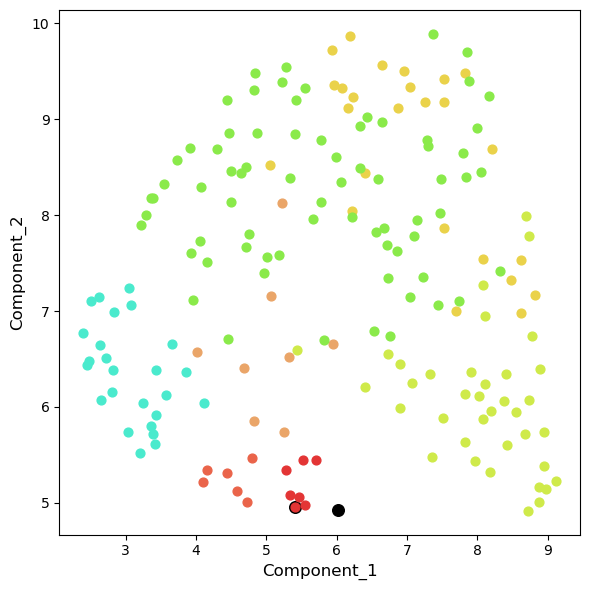

In [90]:
#Fitting and UMAP plotting the best GMM results
def pk_bd(inp):#maybe delete
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(np.abs(inp))
    inp = scaler.transform(inp)
    org = []
    org.append(max(inp[:,0]))
    org.append(max(inp[:,1]))
    org.append(max(inp[:,2]))
    org.append(max(inp[:,3]))
    org.append(max(inp[:,4]))
    org.append(max(inp[:,5]))
    org.append(max(inp[:,6]))
    org.append(max(inp[:,7]))
    org.append(max(inp[:,8]))
    org.append(max(inp[:,9]))
    dist =[]
    for i in inp:
        dist.append(np.linalg.norm(i - org))
    return(dist)



def sm_ggm_10(inp):
    bil = []
    gmm_all.append(["Scores"])
    avv = np.array(np.abs(inp))
    avv[:,0] = -avv[:,0]
    avv[:,7] = -avv[:,7]
    avv[:,8] = -avv[:,8]
    avv[:,9] = -avv[:,9]
    fnd = pk_bd(avv)
    scaler_m = preprocessing.MinMaxScaler()
    scaler_m.fit(avv)
    avv2 = scaler_m.transform(avv)
    lowest_bic = np.infty
    bic = []
    n_components_range = range(4, 11)
    cv_types = ['full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                        covariance_type=cv_type)
            gmm.fit(avv2)
            bic.append(gmm.aic(avv2))
            gmm_all[-1].append(bic[-1]) 
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm  
                
    bic = np.array(bic)
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                'darkorange','maroon','gold','thistle',
                                'peachpuff','lightsteelblue','pink'])
    clf = best_gmm
    plt.figure(figsize=(6, 6))
    splot = plt.subplot(1, 1, 1)
    Y_ = clf.predict(avv2)
    reducer = umap.UMAP(n_components=2,n_neighbors=50,min_dist=0.25,random_state=2)
    reducer.fit(mmft(avv2))
    pc = reducer.transform(mmft(avv2))#used to have standardizer here
    scord = np.argmin(pk_bd(avv))

    orient_p = np.arange(0,1.05,0.05)
    orient = []
    for dim in range(10):
        orient.append(orient_p)
    orient = np.array(orient)
    orient = reducer.transform(orient.T)
    plt.scatter(pc[scord,0],pc[scord,1],c='k',s=70)

    refrence = reducer.transform([[1,1,1,1,1,1,1,1,1,1]])
    plt.scatter(refrence[0,0],refrence[0,1],c='k',s=70)
    LLL = ['#1100FF', '#4AA7EA','#4AE2EA','#4AEACD','#8AEA4A' ,'#CFEA4A','#EAD24A','#EAA568', "#EA644A" ,"#E33535"]
    LLL.reverse()
    color_iter = itertools.cycle(LLL)
    Y_v_list = []
    for i in range(max(Y_)+1):
        Y_v = [fnd[v[0]] for v in enumerate(Y_) if v[1] == i]
        Y_v_list.append(np.mean(Y_v))#appends max value by increasing Y_ labels
    Y_v_list_2 = copy.deepcopy(Y_v_list)
    colors_p = copy.deepcopy(LLL)
    cl = np.arange(10)
    cl = list(cl)
    Y_score = []
    for sort_val in enumerate(np.argsort(Y_v_list)):
        sc = colors_p[sort_val[0]]
        Y_score.append(cl[sort_val[1]])
        cl[sort_val[1]] = str(sc)
    Y_score.reverse()
    #mapping Y_ indexes to scores
    for index_v in enumerate(Y_):
        gmm_all_scores[index_v[0]+1].append(Y_score.index(index_v[1]))
    for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                            color_iter)):
        if not np.any(Y_ == i):
            continue
        plt.scatter(pc[Y_ == i, 0], pc[Y_ == i, 1], 40, c=cl[i])
    plt.xlabel('Component_1',fontsize=12)
    plt.ylabel('Component_2',fontsize=12)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    plt.subplots_adjust(hspace=.35, bottom=.02)
    plt.tight_layout()
    #plt.savefig("Plots/PK/pk_gmm_full_1ug.pdf",dpi=300)
    plt.show()

gmm_all = [["# Components","4 Components",
          "5 Components", "6 Components", "7 Components", "8 Components", "9 Components",
          "10 Components"]]

gmm_all_scores = [["PKA Conditions",'Score']]

for i in range(len(ain)):
    gmm_all_scores.append([pl[i]])

sm_ggm_10(np.abs(np.reshape(np.array(pk_a_1),(-1,10))))

In [91]:
#Displaying tabulated results

gmm_all_aic = pd.DataFrame(gmm_all)
gmm_all_scores = pd.DataFrame(gmm_all_scores)

from IPython.display import display, HTML

print('AIC of GMMs fit to 1.0 µg PK/mL data:')
display(HTML(gmm_all_aic.to_html()))

print('ID+Tag scores from best GMM fit to 1.0 µg/mL PK data:')
display(HTML(gmm_all_scores.to_html()))



AIC of GMMs fit to 1.0 µg PK/mL data:


,0,1,2,3,4,5,6,7
0,# Components,4 Components,5 Components,6 Components,7 Components,8 Components,9 Components,10 Components
1,Scores,-7881.228196,-8173.316161,-8200.157754,-8647.085757,-8461.758314,-8484.498468,-8631.520459


ID+Tag scores from best GMM fit to 1.0 µg/mL PK data:


,0,1
0,PKA Conditions,Score
1,Tag-6/6-Biotin antigen [1 ug] format 1,2
2,Tag-8/6-Biotin antigen [1 ug] format 1,2
3,Tag-9/6-Biotin antigen [1 ug] format 1,2
4,Tag-12/6-Biotin antigen [1 ug] format 1,2
5,Tag-17/6-Biotin antigen [1 ug] format 1,2
6,Generic-Tag/6-Biotin antigen [1 ug] format 1,1
7,Tag-6/8-Biotin antigen [1 ug] format 1,3
8,Tag-8/8-Biotin antigen [1 ug] format 1,3
9,Tag-9/8-Biotin antigen [1 ug] format 1,1
